# Neural Networks

An artificial neural network is a predictive model motivated by the way the brain operates.  The brain is a collection of neurons wired together, and each neuron looks at the outputs of the other neurons that feed into it, does a calculation, and then either fires if the calculation exceeds some threshold or doesn't if the condition isn't met.

Artificial neural networks consist of artificial neurons, which perform similar calculations over their inputs.  Neural networks can solve a wide variety of problems like handwriting recognition and face detection.  They are used quite heavily in deep learning, which is one of the trendiest fields of data science.  However, most neural networks are "black boxes", meaning that inspecting their detail doesn't giove you much understanding of how they are solving a problem.  Large neural networks can be difficult to train, and for most problems, they are probably not the right choice.

Pretty much the simplest neural network is the *perceptron*.  Which approximates a single neuron with *n* binary inputs.  It computes a weighted sum of its inputs and "fires" if that weighted sum is zero or greater:

In [1]:
from collections import Counter
from functools import partial
from code_python3.linear_algebra import dot
import math, random
import matplotlib
import matplotlib.pyplot as plt

def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    return step_function(dot(weights, x) + bias)

The perceptron is simply distinguishing between the half spaces separated by the hyperplane of points `x` for which:

```python
dot(weights,x) + bias = 0
```

With properly chosen weights, perceptrons can solve a number of simple problems.  For example, we can create an AND gate which returns 1 if both its inputs are 1 but returns 0 if one if its inputs is 0.  It can look like:

```python
weights = [2,2]
bias = -3
```

If both inputs are 1, the `calculation` equals 2 + 2 - 3 = 1, and the output is 1.  If only one of the inputs are 1, the `calculation` equals 2 + 0 - 3 = -1, and the output is 0.  Similarly, we could build an OR gate with:

```python
weights = [2.2]
bias = -1
```

and we could build a NOT gate (which has one input and converts 1 to 0 and 0 to 1) with:

```python
weights = [-2]
bias = 1
```

However, there are some problems that simply can't be solved by a single perceptron.  For example, no matter how hard you try, you cannot use a perceptron to build an XOR gate that outputs 1 if exactly one of its inputs is 1 and 0 otherwise.  This is where we start needing more complicated neural networks.  Of course, you don't need to approximate a neuron in order to build a logic gate:

```python
and_gate = min
or_gate = max
xor_gate = lambda x,y: 0 if x == y else 1
```

Like real neurons, artificial neurons start getting more interesting when you start connecting them together.

*Feed forward neural networks* consist of discrete layers of neurons, each connected to the next.  This typically entails an input layer, one or more "hidden layers", each of which consists of neurons that take the outputs of the previous layer, performs some calculation, and passes the result to the next layer, and an output layer which produces the final outputs.  Just like the perceptron, each noninput neuron has a weight corresponding to each of its inputs and a bias.  To make our representation simpler, we'll add the bias to the end of our weights vector and give each neuron a bias input that always equals 1.

As with the perceptron, for each neuron, we'll sum up the products of its inputs and its weights.  But here, rather than outputing the `step_function` applied to that product, we'll output a smooth approximation of the step function.  In particular, we'll use the `sigmoid` function:

In [2]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

Why use `sigmoid` instead of the simpler `step_function`?  In order to train a neural network, we'll need to use calculus, and in order to use calculus, we need smooth functions.  The step function isn't even continuous, and sigmoid is a good smooth approximation of it.  We then calculate the output as:

In [3]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

Given this function, we can represent a neuron simply as a list of weights whose length is one more than the number of inputs to that neuron because of the bias weight.  Then we can represent a neural network as a list of noninput *layers*, where each layer is just a list of the neurons in that layer.  That is, we'll represent a neural network as a list (layers) of lists (neurons) of lists (weights).  Given such a representation, using the neural network is quite simple:

In [4]:
def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input"""

    outputs = []

    for layer in neural_network:

        input_with_bias = input_vector + [1]             # add a bias input
        output = [neuron_output(neuron, input_with_bias) # compute the output
                  for neuron in layer]                   # for this layer
        outputs.append(output)                           # and remember it

        # the input to the next layer is the output of this one
        input_vector = output

    return outputs

Now it's easy to build the XOR gate that we couldn't build with a single perceptron.  We just need to scale the weights up so that the neuron outputs are either really close to 0 or really close to 1:

In [5]:
xor_network = [
    [
        [20, 20, -30],   # 'and' neuron
        [20, 20, -10]    # 'or' neuron
    ],
    # output layer
    [
        [-60, 60, -30]
    ]
]

for x in [0,1]:
    for y in [0,1]:
        # feed forward produces the outputs of every neuron
        # feed forward[-1] is the outputs of the output-layer neurons
        print(x, y, feed_forward(xor_network, [x, y])[-1])

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


By using a hidden layer, we are able to feed the output of an "and" neuron and the output of an "or" neuron into a "second input but not first input" neuron.  The result is a network that performs "or, but not and", which is precisely XOR.

Usually we don't build neural networks by hand.  This is in part because we use them to solve much bigger problems.  Instead, we use data to *train* neural networks.  One popular approach is an algorithm called *backpropagation* that has similiaries to the gradient descent algorithm from previous chapters.

Imagine we have a training set that consists of input vectors and corresponding target output vectors.  For example, in our previous `xor_network` example, the input vector `[1,0]` corresponded to the target output `[1]`.  And imagine that our network has some set of weights.  We then adjust the weight using the following algorithm:

1. Run `feed_forward` on an input vector to produce the output of all the neurons in the network.
2. This results in an error for each output neuron -- the difference between ints output and its target.
3. Compute the gradient of this error as a function of the neuron's weights, and adjust its weights in the direction that most decreases the error.
4. "Propagate" these output errors backward to infer errors for the hidden layer.
5. Compute the gradients of these errors and adjust the hidden layer's weights in the same manner.

Typically we run this algorithm many timesa for our entire training set until the network converges:

In [6]:
def backpropagate(network, input_vector, target):

    hidden_outputs, outputs = feed_forward(network, input_vector)

    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target[i])
                     for i, output in enumerate(outputs)]

    # adjust weights for output layer (network[-1])
    for i, output_neuron in enumerate(network[-1]):
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            output_neuron[j] -= output_deltas[i] * hidden_output

    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                      dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer (network[0])
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

This is pretty much doing the same thing as if you explicitly wrote the squared error as a function of the weights and used the `minimize_stochastic` function we built previously.

Our neural network wants an input to be a vector of numbers.  So we'll transform each image to a vector length 25, whose elements are either 1 or 0.  We'll want our output to indicate which digit the neural network thinks it is, so we'll need 10 outputs.  Then, assuming our inputs are correctly ordered from 0 to 9, our targets will be:

In [7]:
raw_digits = [
      """11111
         1...1
         1...1
         1...1
         11111""",

      """..1..
         ..1..
         ..1..
         ..1..
         ..1..""",

      """11111
         ....1
         11111
         1....
         11111""",

      """11111
         ....1
         11111
         ....1
         11111""",

      """1...1
         1...1
         11111
         ....1
         ....1""",

      """11111
         1....
         11111
         ....1
         11111""",

      """11111
         1....
         11111
         1...1
         11111""",

      """11111
         ....1
         ....1
         ....1
         ....1""",

      """11111
         1...1
         11111
         1...1
         11111""",

      """11111
         1...1
         11111
         ....1
         11111"""]

def make_digit(raw_digit):
    return [1 if c == '1' else 0
            for row in raw_digit.split("\n")
            for c in row.strip()]

inputs = list(map(make_digit, raw_digits))

targets = [[1 if i == j else 0 for i in range(10)]
           for j in range(10)]

At which point we're ready to build our neural network:

In [8]:
random.seed(0)   # to get repeatable results
input_size = 25  # each input is a vector of length 25
num_hidden = 5   # we'll have 5 neurons in the hidden layer
output_size = 10 # we need 10 outputs for each input

# each hidden neuron has one weight per input, plus a bias weight
hidden_layer = [[random.random() for __ in range(input_size + 1)]
                for __ in range(num_hidden)]

# each output neuron has one weight per hidden neuron, plus a bias weight
output_layer = [[random.random() for __ in range(num_hidden + 1)]
                for __ in range(output_size)]

# the network starts out with random weights
network = [hidden_layer, output_layer]

And we can train it with the backpropagation algorithm:

In [9]:
# 10,000 iterations seems enough to converge
for __ in range(10000):
    for input_vector, target_vector in zip(inputs, targets):
        backpropagate(network, input_vector, target_vector)
        
def predict(input):
    return feed_forward(network, input)[-1]

predict(inputs[7])

[0.024382157616321443,
 4.684195501636839e-06,
 1.6849128340309735e-11,
 0.0180391464806713,
 0.0007894951820384888,
 5.409231346799728e-10,
 4.3230780100206996e-08,
 0.9698049702048102,
 6.704747602428434e-09,
 1.3671928428594845e-08]

WHich indicates that the digit 7 output neuron produces 0.97, while all the other output neurons produce very small numbers.  Although the network's operation is not exactly transparent, we can inspect the weights of the hidden layers to get a sense of what they are recognizing, in particular, we can plot the weights of each neuron as a 5x5 grid corresponding to the 5x5 inputs:

In [13]:
for i, input in enumerate(inputs):
    outputs = predict(input)
    print(i, [round(p,2) for p in outputs])

print(""".@@@.
...@@
..@@.
...@@
.@@@.""")
print([round(x, 2) for x in
      predict(  [0,1,1,1,0,    # .@@@.
                 0,0,0,1,1,    # ...@@
                 0,0,1,1,0,    # ..@@.
                 0,0,0,1,1,    # ...@@
                 0,1,1,1,0])]) # .@@@.
print()

print(""".@@@.
@..@@
.@@@.
@..@@
.@@@.""")
print([round(x, 2) for x in
      predict(  [0,1,1,1,0,    # .@@@.
                 1,0,0,1,1,    # @..@@
                 0,1,1,1,0,    # .@@@.
                 1,0,0,1,1,    # @..@@
                 0,1,1,1,0])]) # .@@@.

0 [0.96, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.03, 0.0]
1 [0.0, 0.96, 0.03, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 0.02, 0.96, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0]
3 [0.0, 0.03, 0.0, 0.97, 0.0, 0.0, 0.0, 0.02, 0.0, 0.03]
4 [0.0, 0.02, 0.01, 0.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0]
5 [0.0, 0.0, 0.02, 0.0, 0.0, 0.96, 0.01, 0.0, 0.02, 0.01]
6 [0.0, 0.0, 0.01, 0.0, 0.01, 0.01, 0.99, 0.0, 0.0, 0.0]
7 [0.02, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.97, 0.0, 0.0]
8 [0.04, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.96, 0.03]
9 [0.0, 0.0, 0.0, 0.01, 0.0, 0.02, 0.0, 0.0, 0.03, 0.95]
.@@@.
...@@
..@@.
...@@
.@@@.
[0.0, 0.01, 0.0, 0.97, 0.0, 0.0, 0.0, 0.01, 0.0, 0.1]

.@@@.
@..@@
.@@@.
@..@@
.@@@.
[0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 0.0, 0.0, 0.96, 1.0]


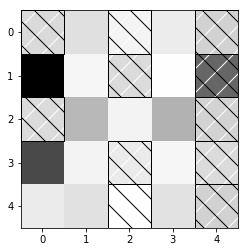

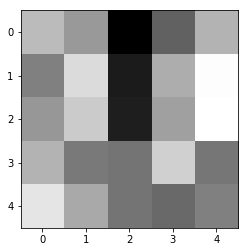

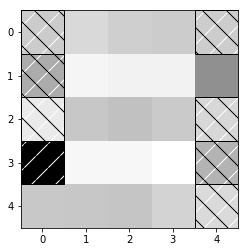

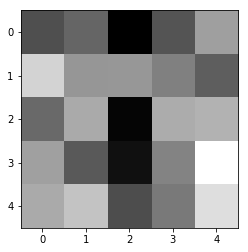

In [20]:
def patch(x, y, hatch, color):
    """return a matplotlib 'patch' object with the specified
    location, crosshatch pattern, and color"""
    return matplotlib.patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                        hatch=hatch, fill=False, color=color)

def show_weights(neuron_idx):
    weights = network[0][neuron_idx]
    abs_weights = [abs(weight) for weight in weights]

    grid = [abs_weights[row:(row+5)] # turn the weights into a 5x5 grid
            for row in range(0,25,5)] # [weights[0:5], ..., weights[20:25]]

    ax = plt.gca() # to use hatching, we'll need the axis

    ax.imshow(grid, # here same as plt.imshow
              cmap=matplotlib.cm.binary, # use white-black color scale
              interpolation='none') # plot blocks as blocks

    # cross-hatch the negative weights
    for i in range(5): # row
        for j in range(5): # column
            if weights[5*i + j] < 0: # row i, column j = weights[5*i + j]
                # add black and white hatches, so visible whether dark or light
                ax.add_patch(patch(j, i, '/', "white"))
                ax.add_patch(patch(j, i, '\\', "black"))
    plt.show()
    
show_weights(0)
show_weights(1)
show_weights(2)
show_weights(3)

We see the first hidden neuron has large positive weights in the left column and in the center of the middle row, while it has large negative weights in the right column.  On those inputs, it does what you'd expect:

In [21]:
left_column_only = [1, 0, 0, 0, 0] * 5
print(feed_forward(network, left_column_only)[0][0])

center_middle_row = [0, 0, 0, 0, 0] * 5
print(feed_forward(network, center_middle_row)[0][0])

right_column_only = [0, 0, 0, 0, 1] * 5
print(feed_forward(network, right_column_only))

0.9999891931095952
0.007128731038157492
[[1.2885453726823725e-09, 0.9689434353613953, 0.0014204929460003945, 0.9831123286718932, 3.694766808960256e-05], [0.15184726081855648, 1.977719860654913e-06, 1.1719495168352514e-11, 0.007084473598436873, 0.002042164504235355, 2.8408705017464553e-10, 1.3086865586678795e-07, 0.9866434205668683, 8.815605117295454e-09, 2.5873730366856654e-09]]
